In [ ]:
# default_exp predict

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Prediction
> Functions that wrap prediction tasks

All predictions are given as a score between 0 (for grade 1) and 1 (for grade 3).

In [ ]:
# export
from grade_classif.core import ifnone
from grade_classif.data.utils import load_batches
from grade_classif.models.plmodules import GradesClassifModel
from grade_classif.data.read import get_scan
from grade_classif.imports import *

In [ ]:
# export
def predict_one_scan_one_level(model, fn):
    preds = []
    for x in load_batches(fn, bs=model.bs, device=model.main_device):
        preds.append(model.predict(x).detach().cpu()[:, 1])
    preds = torch.cat(preds)
    return preds.sum().item()/len(preds)

Returns - for one zoom level - the prediction for one single scan `fn` (as a `Path` to the corresponding folder) using `model`. Returns the mean result of all patches.

In [ ]:
# export
def predict_one_scan(hparams):
    preds = []
    for level, version, norm_version in zip(hparams.levels, hparams.versions, hparams.norm_versions):
        hparams.level = level
        hparams.norm_version = norm_version
        model = GradesClassifModel(hparams)
        model.load(version)
        path = get_scan(hparams.full_data/f'{hparams.full_data.name}_{level}', hparams.scan, include=['1', '3'])
        preds.append(predict_one_scan_one_level(model, path))
    preds = torch.cat(preds)
    return preds.sum().item()/len(preds)

Returns a prediction for one scan over multiple levels. All parameters (such as levels for prediction, models to use or scan to predict) are defined in `hparams`.

In [ ]:
# export
def predict_all(hparams):
    df = pd.read_csv(hparams.data_csv, header='infer')
    preds = []
    scans = []
    levels = []
    for level, version, norm_version in zip(hparams.levels, hparams.versions, hparams.norm_versions):
        hparams.level = level
        hparams.norm_version = norm_version
        model = GradesClassifModel(hparams)
        model.load(version)
        for row in tqdm(df.loc[df['split']=='valid'].values):
            scan, grade = row[:-1]
            fn = hparams.full_data/f'{hparams.full_data.name}_{level}'/str(grade)/scan
            try:
                preds.append(predict_one_scan_one_level(model, fn))
            except FileNotFoundError:
                continue
            scans.append(scan)
            levels.append(level)
    res = pd.DataFrame({'level': levels, 'scan': scans, 'pred': preds})
    return res

Compute predictions for all validation scans. All parameters are defined in `hparams`. This function returns a dataframe that contains the score for each scan.

In [ ]:
from grade_classif.params.parser import hparams
df = predict_all(hparams)

100%|██████████| 227/227 [08:47<00:00,  2.32s/it]


In [ ]:
def plot_metrics(hparams, pred_df=None):    
    df = pred_df if pred_df is not None else predict_all(hparams)
    scan_df = pd.read_csv(hparams.data_csv, header='infer')
    scan_df = scan_df.loc[scan_df['split']=='valid']
    scan_df = scan_df.set_index('scan')
    scan_df = scan_df.reindex(index=df['scan'])
    scan_df = scan_df.reset_index()

    preds = df['pred'].values
    gt = (scan_df['grade'].values == 3)

    thrs = [0.001*k for k in range(1000)]

    tp = np.zeros(len(thrs))
    fp = np.zeros(len(thrs))
    tn = np.zeros(len(thrs))
    fn = np.zeros(len(thrs))

    for k, thr in enumerate(thrs):
        p = preds > thr
        tp[k] = (p & gt).sum()
        fp[k] = (p & ~gt).sum()
        tn[k] = (~p & ~gt).sum()
        fn[k] = (~p & gt).sum()

    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    axs = axs.flatten()
    prec = (tp+1e-7)/(tp+fp+1e-7)
    rec = (tp+1e-7)/(tp+fn+1e-7)
    axs[0].plot(thrs, prec, label='prec grade 3')
    axs[0].plot(thrs, rec, label='recall grade 3')
    axs[2].plot(thrs, (2*prec*rec)/(prec+rec), label='grade 3')
    prec = (tn+1e-7)/(tn+fn+1e-7)
    rec = (tn+1e-7)/(tn+fp+1e-7)
    axs[1].plot(thrs, prec, label='prec grade 1')
    axs[1].plot(thrs, rec, label='recall grade 1')
    axs[2].plot(thrs, (2*prec*rec)/(prec+rec), label='grade 1')
    axs[3].plot(thrs, (tp+tn)/(tp+tn+fp+fn), label='accuracy')
    axs[0].set_title('grade 3 precision/recall')
    axs[1].set_title('grade 1 precision/recall')
    axs[2].set_title('f1 scores')
    axs[3].set_title('accuracy')
    for ax in axs:
        ax.legend()
    plt.show()
    return tp, fp, tn, fn

In [ ]:
def get_groups(scan_df, pred_df, thr=0.5):
    scan_df = pd.read_csv(hparams.data_csv, header='infer')
    scan_df = scan_df.loc[scan_df['split']=='valid']
    scan_df = scan_df.set_index('scan')
    scan_df = scan_df.reindex(index=pred_df['scan'])
    scan_df = scan_df.reset_index()

    p = pred_df['pred'].values > thr
    gt = (scan_df['grade'].values == 3)
    groups = np.zeros(len(p), dtype='object')
    groups[p & gt] = 'true_3'
    groups[~p & ~gt] = 'true_1'
    groups[~p & gt] = 'false_1'
    groups[p & ~gt] = 'false_3'
    new_df = pd.DataFrame({'scan': scan_df['scan'], 'group': groups.tolist()})
    return new_df

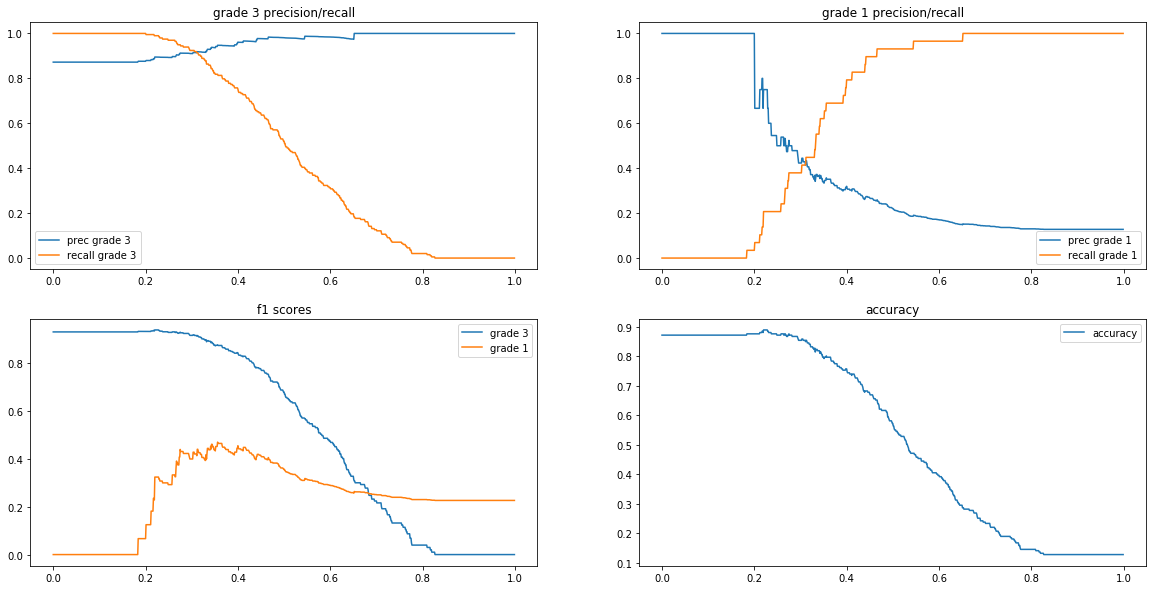

In [ ]:
tp, fp, tn, fn = plot_metrics(hparams, df)

In [ ]:
scan_df = pd.read_csv(hparams.data_csv, header='infer')

In [ ]:
group_df = get_groups(scan_df, df, thr=0.35)

In [ ]:
df[df['scan'].isin(group_df.loc[group_df['group'] == 'false_1', 'scan'])]

,level,scan,pred
29,1,CF_PACS04rescan_06P0674,0.294058
32,1,CF_PACS04rescan_10F0310,0.344126
39,1,CF_PACS04rescan_06P0864,0.314873
44,1,CF_PACS04rescan_06P1108,0.267493
48,1,CF_PACS04rescan_06P061,0.230717
54,1,CF_PACS04rescan_06P1356,0.218150
55,1,CF_PACS04rescan_06P1345,0.328432
56,1,CF_PACS04rescan_06P117,0.269088
59,1,CF_PACS04rescan_06P211,0.318427
61,1,CF_PACS04rescan_06P1292,0.248054


In [ ]:
df.loc[df['scan']=='CF_PACS04rescan_06P0674']

,level,scan,pred
29,1,CF_PACS04rescan_06P0674,0.294058


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_train.ipynb.
Converted 02_predict.ipynb.
Converted 10_data.read.ipynb.
Converted 11_data.loaders.ipynb.
Converted 12_data.dataset.ipynb.
Converted 13_data.utils.ipynb.
Converted 14_data.transforms.ipynb.
Converted 20_models.plmodules.ipynb.
Converted 21_models.modules.ipynb.
Converted 22_models.utils.ipynb.
Converted 23_models.hooks.ipynb.
Converted 24_models.metrics.ipynb.
Converted 25_models.losses.ipynb.
Converted 80_params.defaults.ipynb.
Converted 81_params.parser.ipynb.
Converted 99_index.ipynb.
